In [127]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [151]:
df = pd.read_csv("data/finanzas_hotel_bookings.csv", index_col=0, low_memory=False)

In [152]:
# Eliminamos ultimas filas que tienen en su mayoría valores nulos y no sirven para el análisis
df = df.iloc[:119390]

In [153]:
df.drop("0", axis = 1, inplace = True) # Elimina la COLUMNA y sobreescribe los cambios

In [103]:
def convertir_a_boleano(df, columnas):
    """
    Convierte las columnas especificadas de un DataFrame a tipo booleano.

    Parámetros:
    df (pandas.DataFrame): El DataFrame en el que se encuentran las columnas.
    columnas (list): Lista de nombres de columnas a convertir.

    Retorna:
    pandas.DataFrame: El DataFrame con las columnas convertidas a booleano.
    """
    print(f'El tipo de dato antes del cambio \n {df["is_repeated_guest"].dtype} \n {df["is_canceled"].dtype}')
    
    for columna in columnas:
        df[columna] = df[columna].astype(bool)
    print(f'El tipo de dato después del cambio \n {df["is_repeated_guest"].dtype} \n {df["is_canceled"].dtype}')
    return df


columnas = ["is_repeated_guest", "is_canceled"]
df = convertir_a_boleano(df, columnas)

# Convierte los valores de la columna a positivos
df['adr'] = df['adr'].abs()

El tipo de dato antes del cambio 
 float64 
 object
El tipo de dato después del cambio 
 bool 
 bool


In [104]:
def eliminar_segundo_digito (df, columnas):
    for columna in columnas:
        display(f"{columna.upper()} --> Valores únicos antes de eliminar: {df[columna].nunique()}")
        df[columna] = df[columna].apply(lambda num: num if num < 10 else num // 10 )
        display(f"{columna.upper()} --> Valores únicos después de eliminar: {df[columna].nunique()}")
    return df

columnas = ["adults", "children", "babies"]
df = eliminar_segundo_digito(df, columnas)

'ADULTS --> Valores únicos antes de eliminar: 30'

'ADULTS --> Valores únicos después de eliminar: 7'

'CHILDREN --> Valores únicos antes de eliminar: 14'

'CHILDREN --> Valores únicos después de eliminar: 4'

'BABIES --> Valores únicos antes de eliminar: 14'

'BABIES --> Valores únicos después de eliminar: 4'

In [143]:
df["market_segment"].value_counts()

Online TA        28331
Offline TA/TO    12116
Groups           10008
Direct            6354
Corporate         2643
Complementary      363
Aviation           118
Undefined            1
Name: market_segment, dtype: int64

In [144]:
df["distribution_channel"].value_counts()

TA/TO        86822
Direct       12997
Corporate     5899
GDS            176
Undefined        5
Name: distribution_channel, dtype: int64

In [157]:
import pandas as pd

# Suponiendo que ya tienes tu DataFrame cargado como 'df'
# df = pd.read_csv('tu_archivo.csv')

# Crear la tabla de contingencia con porcentajes
tabla_contingencia_pct = pd.crosstab(df['market_segment'], df['distribution_channel'], normalize='index') * 100

# Mostrar la tabla de contingencia en porcentajes
print(tabla_contingencia_pct)

distribution_channel  Corporate     Direct       GDS      TA/TO  Undefined
market_segment                                                            
Aviation              93.137255   0.000000  0.000000   6.862745        0.0
Complementary         13.931889  75.851393  0.000000  10.216718        0.0
Corporate             90.235546   3.725910  0.000000   6.038544        0.0
Direct                 0.672805  97.415014  0.017705   1.894476        0.0
Groups                 6.123368   7.350293  0.000000  86.526339        0.0
Offline TA/TO          1.015370   0.083838  0.186306  98.714485        0.0
Online TA              0.071765   0.207320  0.259150  99.461765        0.0
Undefined              0.000000   0.000000  0.000000   0.000000      100.0


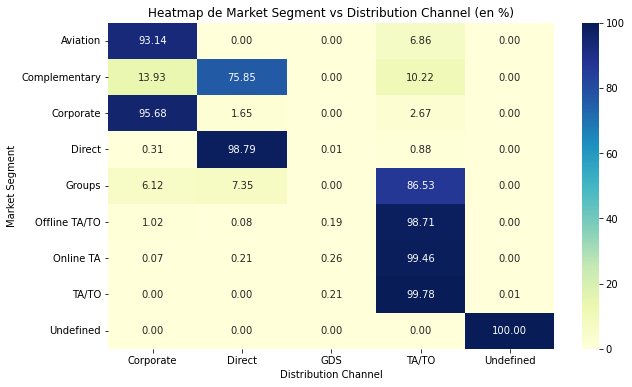

In [164]:
# Crear la tabla de contingencia con porcentajes
tabla_contingencia_pct = pd.crosstab(df['market_segment'], df['distribution_channel'], normalize='index') * 100

# Crear el heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(tabla_contingencia_pct, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)

# Personalizar el heatmap
plt.title('Heatmap de Market Segment vs Distribution Channel (en %)')
plt.ylabel('Market Segment')
plt.xlabel('Distribution Channel')
plt.show()

Conclusiones rápidas:

- El 80% del mercado "aviation" es por el canal "Corporate" y el 14% son Nan. ¿Ponemos esos Nan a Corporate? 

- El 67.49% del mercado "Complementary" es por el canal "Direct" y el 11% Nan. Esos Nan a Direct

- El 80% del mercado "corporate" es por el canal "corporate" y el 11% son Nan. ¿Ponemos esos Nan a Corporate? 

- El 87% de "direct" es por el canal "Direct" y el 11% son Nan. ¿Ponemos esos Nan a Direct? 

- El 77% de "groups" es por el canal "TA/TO" y el 11% son Nan. ¿Ponemos esos Nan a TA/TO? 

- El 72,83 % de los Nan en la columna "market_segment" corresponden a TA/TO en la columna "distribution_channel". ¿Ponemos esos Nan a TA/TO? 

- El 87% de "Offline TA/TO" es por el canal "TA/TO" y el 11% son Nan. ¿Ponemos esos Nan a TA/TO? 

- El 88% de "online TA" es por el canal "TA/TO" y el 11% son Nan. ¿Ponemos esos Nan a TA/TO? 

In [159]:
df["market_segment"].isna().sum()

0

In [160]:
df["distribution_channel"].isna().sum()

13491

Vemos que hay un número muy elevado de adultos en una misma habitación. Vamos a ver si esa habitación corresponde siempre al mismo tipo y sacar conclusiones de que pueda ser un salón de actos, comedor, sala de juntas, etc. 

In [158]:
# Función para imputar valores en la columna 'market_segment'
def imputar_market_segment(row):
    if pd.isnull(row['market_segment']):
        # Reglas para imputar los valores nulos
        if row['distribution_channel'] == 'Aviation':
            return 'Corporate'
        elif row['distribution_channel'] == 'Complementary':
            return 'Direct'
        elif row['distribution_channel'] == 'Corporate':
            return 'Corporate'
        elif row['distribution_channel'] == 'Direct':
            return 'Direct'
        elif row['distribution_channel'] == 'Groups' or 'Offline TA/TO' or 'Online TA':
            return 'TA/TO'
    
    else:
        return row['market_segment']

# Aplicar la función al DataFrame
df['market_segment'] = df.apply(imputar_market_segment, axis=1)

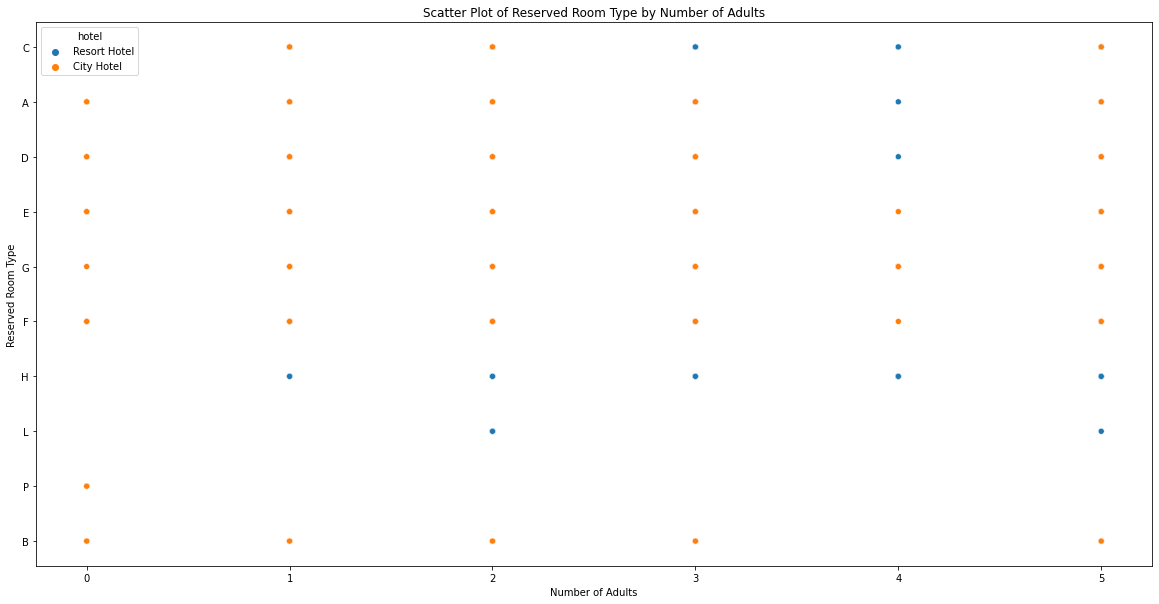

In [105]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='adults', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Adultos por Tipo de Habitación')

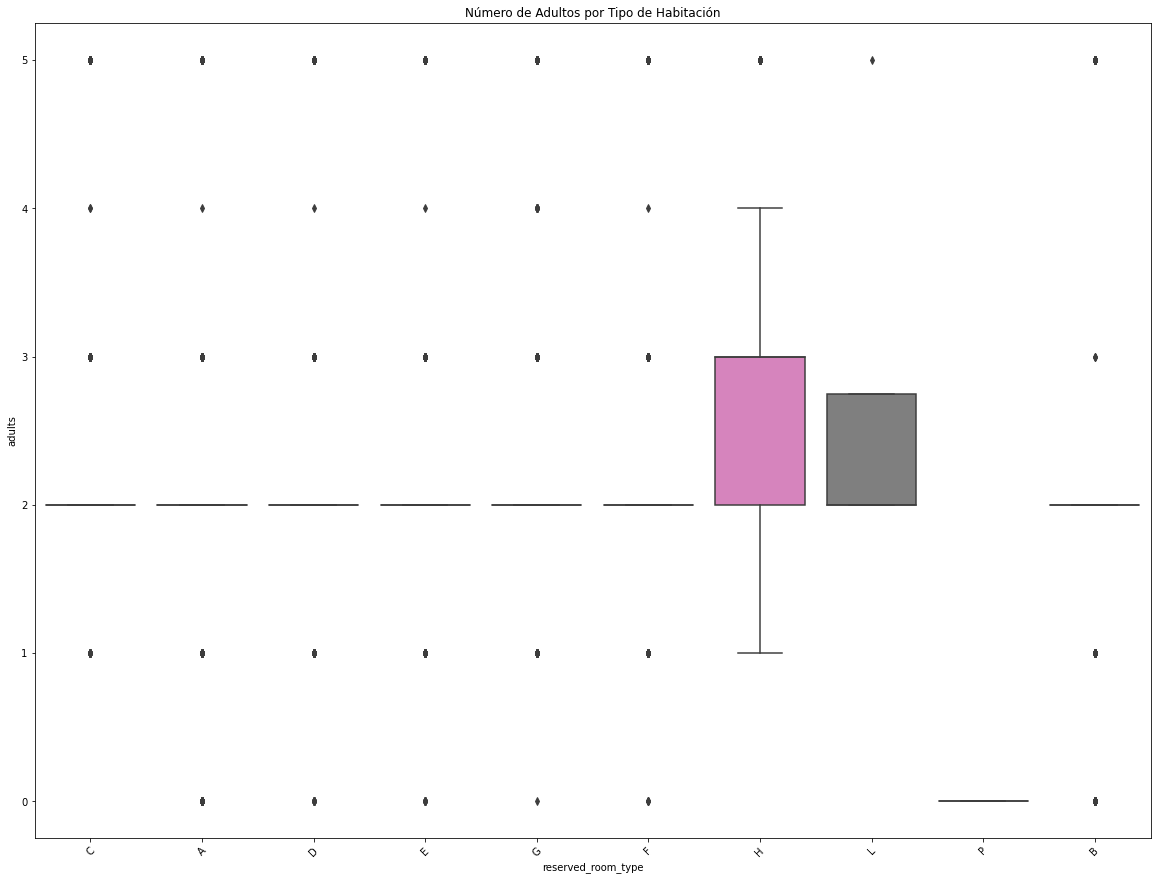

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de adultos
sns.boxplot(x='reserved_room_type', y='adults', data=df)
plt.xticks(rotation=45)
plt.title('Número de Adultos por Tipo de Habitación')

In [108]:
def imputar_nulos_iterative (df, columns):
    """
    Dada una lista de columnas y un DataFrame, esta función completa los nulos de las columnas con el método IterativeImputer.
    Además, redondea los valores imputados a enteros y asegura que no haya valores negativos.
    
    Parámetros:
    df (pd.DataFrame): El DataFrame a procesar.
    columns (list): Lista de nombres de columnas a imputar.
    
    Retorna:
    pd.DataFrame: El DataFrame con los valores nulos imputados.
    """

    # Número de Nan y distribución antes de aplicar el método
    for column in columns:
        print(f"Porcentaje de NaN en '{column}': {df[column].isna().sum() / df.shape[0]:.2f}%")
        print(df[column].value_counts() / df.shape[0] * 100)

    # instanciamos las clases
    imputer_iterative = IterativeImputer(max_iter = 20, random_state = 42)  
    # ajustamos y tranformamos los datos
    imputer_iterative_imputado = imputer_iterative.fit_transform(df[columns])

    # Redondeamos los valores imputados a enteros
    imputer_iterative_imputado = np.round(imputer_iterative_imputado).astype(int)
    
    # Nos aseguramos de que no haya valores negativos
    imputer_iterative_imputado[imputer_iterative_imputado < 0] = 0

    # Asignamos los valores imputados de vuelta al DataFrame
    df[columns] = imputer_iterative_imputado

    # Número de Nan y distribución después de aplicar el método
    for column in columns:
        print(f"Porcentaje de NaN en '{column}': {df[column].isna().sum() / df.shape[0]:.2f}%")
        print(df[column].value_counts() / df.shape[0] * 100)

    return df

columnas = ["children", "previous_cancellations"]
df = imputar_nulos_iterative(df, columnas )

Porcentaje de NaN en 'children': 0.42%
0.0    53.790937
1.0     2.400536
2.0     1.790770
3.0     0.037692
Name: children, dtype: float64
Porcentaje de NaN en 'previous_cancellations': 0.36%
0.0     60.273055
1.0      3.248178
2.0      0.063657
3.0      0.034341
11.0     0.028478
24.0     0.027641
19.0     0.017589
4.0      0.016752
26.0     0.015077
25.0     0.015077
14.0     0.014239
13.0     0.014239
5.0      0.011726
6.0      0.010051
17.0     0.005863
12.0     0.005863
18.0     0.005026
16.0     0.004188
10.0     0.004188
15.0     0.004188
21.0     0.000838
Name: previous_cancellations, dtype: float64
Porcentaje de NaN en 'children': 0.00%
0    95.771003
1     2.400536
2     1.790770
3     0.037692
Name: children, dtype: float64
Porcentaje de NaN en 'previous_cancellations': 0.00%
0     96.452802
1      3.248178
2      0.063657
3      0.034341
11     0.028478
24     0.027641
19     0.017589
4      0.016752
26     0.015077
25     0.015077
14     0.014239
13     0.014239
5      0.01

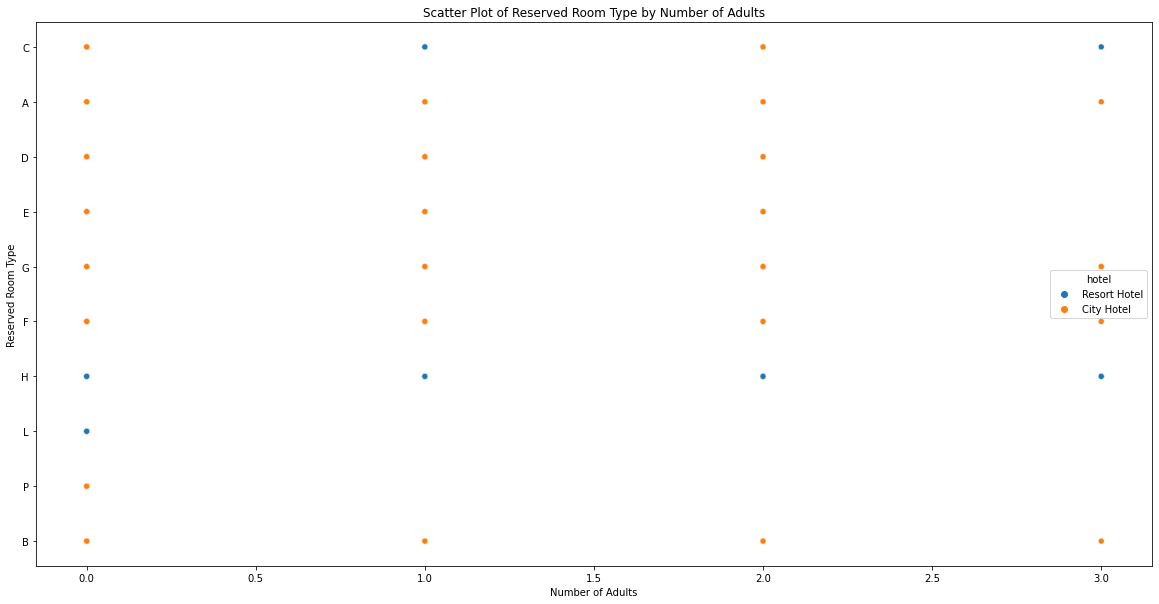

In [109]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='children', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Niños por Tipo de Habitación')

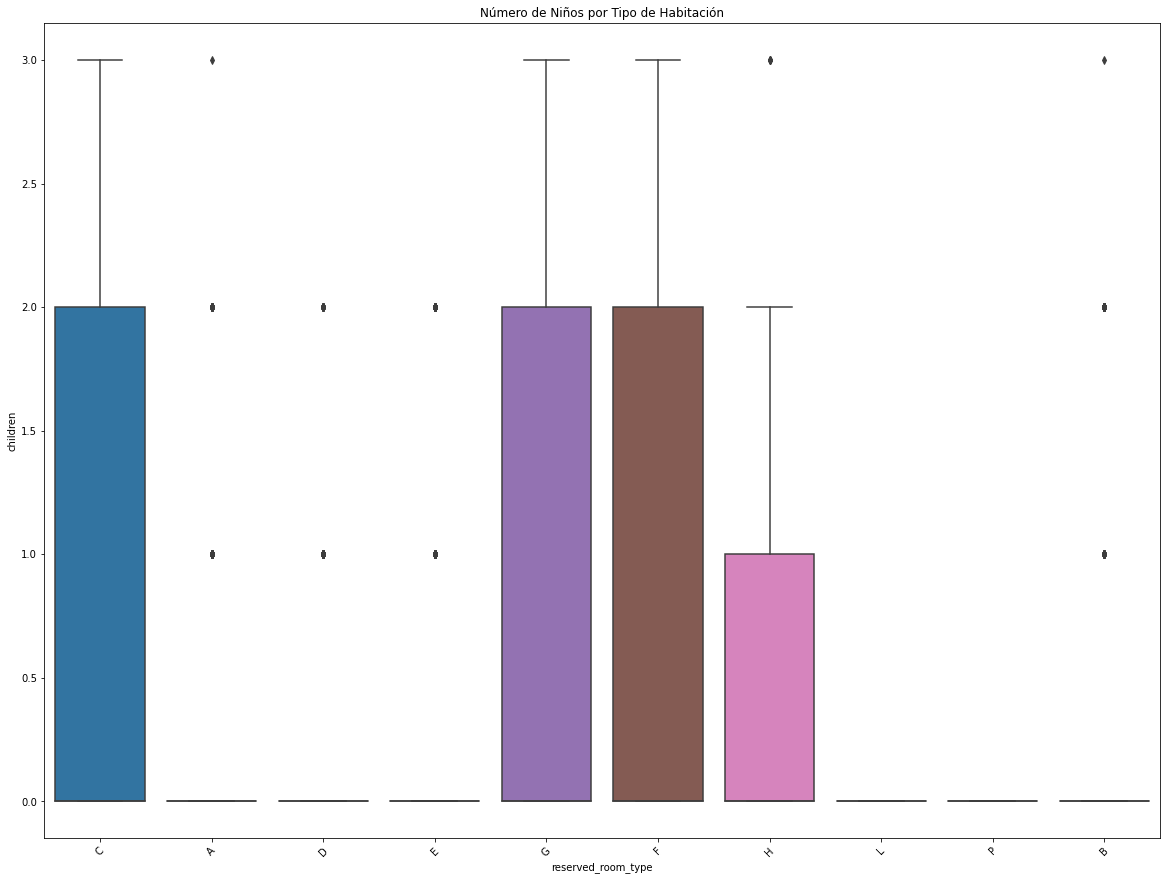

In [110]:
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de niños
sns.boxplot(x='reserved_room_type', y='children', data=df)
plt.xticks(rotation=45)
plt.title('Número de Niños por Tipo de Habitación')

Vemos que hay un número muy elevado de bebes en la misma habitación. Pasando de 2 a más de 9

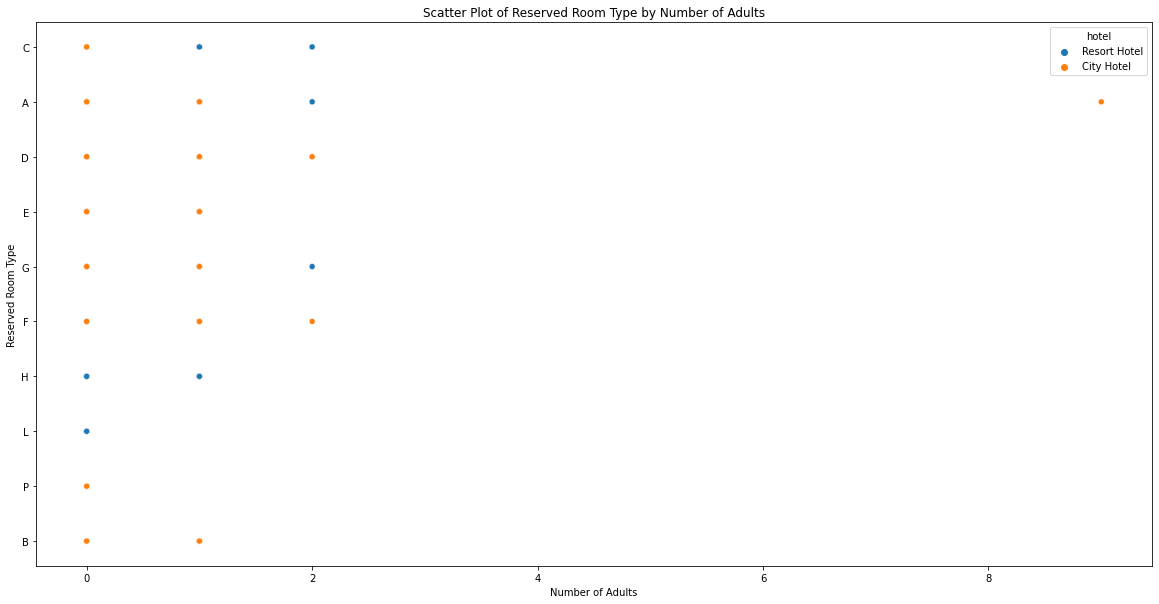

In [111]:
# Graficar la relación entre el número de adultos y el tipo de habitación reservada
plt.figure(figsize=(20, 10))
sns.scatterplot(x='babies', 
                y='reserved_room_type',
                data=df, hue='hotel')
plt.xlabel('Number of Adults')
plt.ylabel('Reserved Room Type')
plt.title('Scatter Plot of Reserved Room Type by Number of Adults')
plt.show()

Text(0.5, 1.0, 'Número de Bebés por Tipo de Habitación')

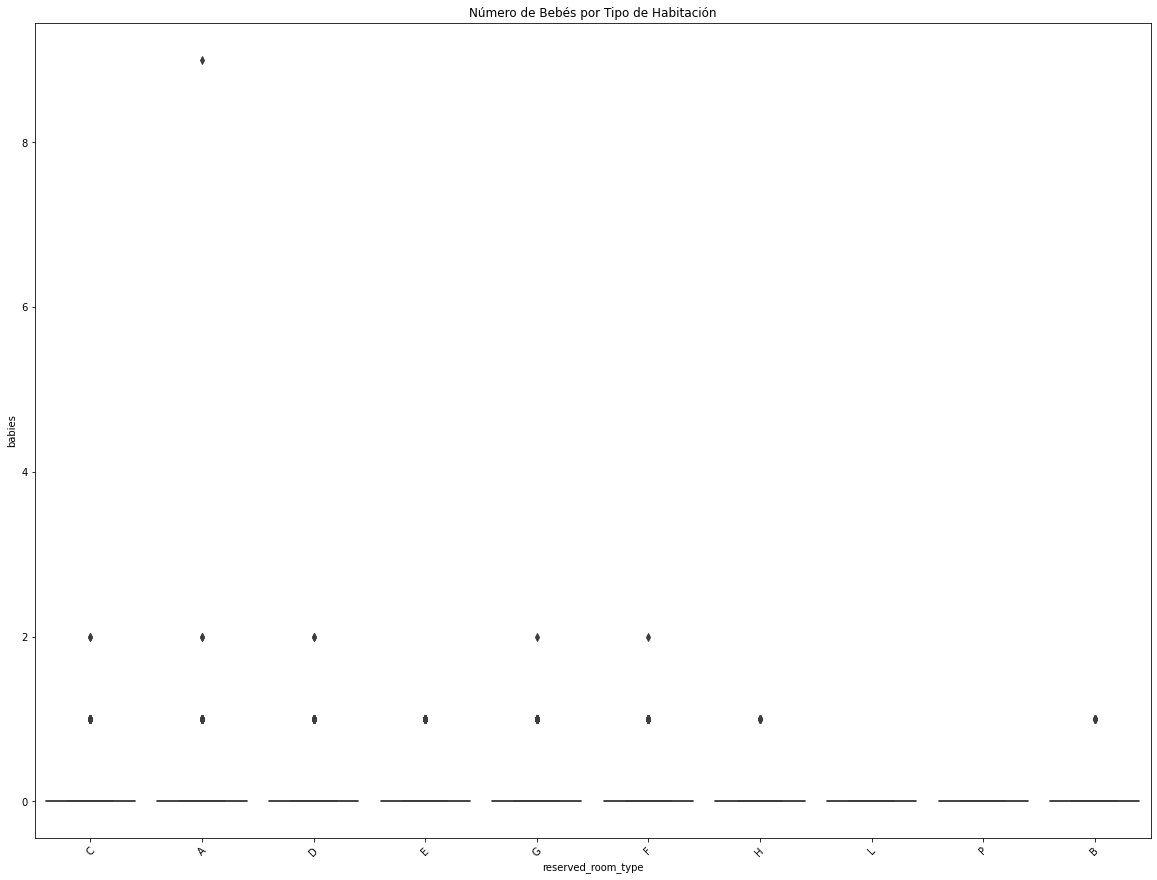

In [112]:
plt.figure(figsize=(20, 15))
# Relación entre el tipo de habitación y el número de bebés
sns.boxplot(x='reserved_room_type', y='babies', data=df)
plt.xticks(rotation=45)
plt.title('Número de Bebés por Tipo de Habitación')

In [113]:
df_mas_de30_adultos = df[df["adults"]>30]

In [114]:
df_mas_de30_adultos.tail()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date


In [115]:
df_mas_de30_adultos["customer_type"].value_counts()

Series([], Name: customer_type, dtype: int64)

No se ve ningún patrón que explique un número elevado de adultos en la habitación, nos quedamos con el primer digito. 

In [116]:
df['market_segment'] = df['market_segment'].fillna('NaN')
df['distribution_channel'] = df['distribution_channel'].fillna('NaN')

SyntaxError: invalid syntax (2438215086.py, line 1)

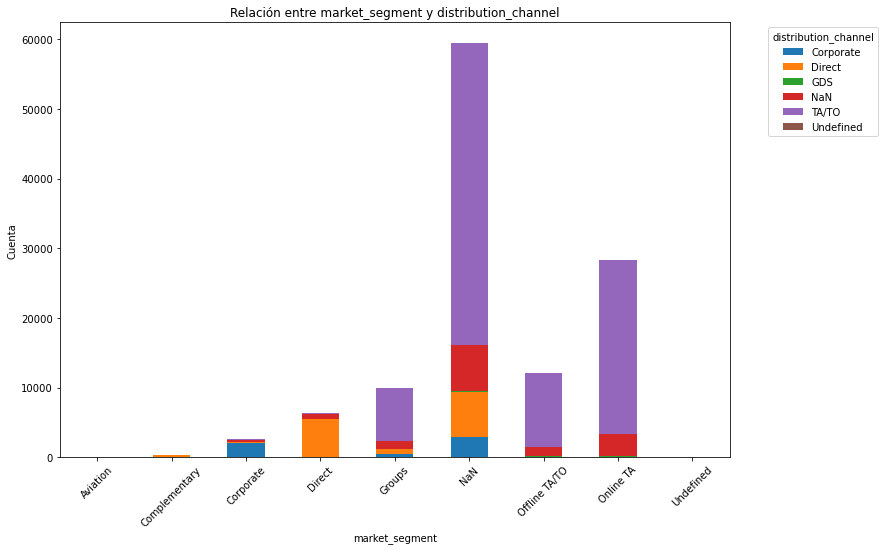

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Crea una tabla de contingencia
contingency_table = pd.crosstab(df['market_segment'], df['distribution_channel'])

# Grafica la tabla de contingencia como barras apiladas
contingency_table.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Relación entre market_segment y distribution_channel')
plt.xlabel('market_segment')
plt.ylabel('Cuenta')
plt.xticks(rotation=45)
plt.legend(title='distribution_channel', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


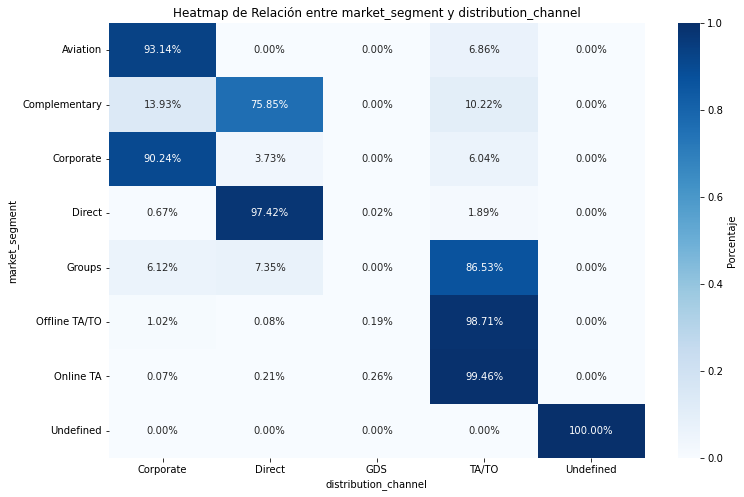

In [145]:
# Crear una tabla de contingencia para el heatmap
contingency_table = pd.crosstab(df['market_segment'], df['distribution_channel'], normalize='index')

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt=".2%", cmap='Blues', cbar_kws={'label': 'Porcentaje'})

plt.title('Heatmap de Relación entre market_segment y distribution_channel')
plt.xlabel('distribution_channel')
plt.ylabel('market_segment')
plt.show()

In [163]:
import pandas as pd

# Crear la tabla de contingencia con porcentajes 
tabla_contingencia_pct = pd.crosstab(df['distribution_channel'], df['market_segment'], normalize='index') * 100

# Mostrar la tabla de contingencia en porcentajes
print(tabla_contingencia_pct)

market_segment        Aviation  Complementary  Corporate     Direct    Groups  \
distribution_channel                                                            
Corporate             1.610442       0.762841  85.607730   0.644177  9.221902   
Direct                0.000000       1.885050   0.669385  91.951989  5.024236   
GDS                   0.000000       0.000000   0.000000   0.568182  0.000000   
TA/TO                 0.008062       0.038009   0.162401   0.123241  8.853747   
Undefined             0.000000       0.000000   0.000000   0.000000  0.000000   

market_segment        Offline TA/TO  Online TA      TA/TO  Undefined  
distribution_channel                                                  
Corporate                  1.847771   0.305136   0.000000        0.0  
Direct                     0.069247   0.400092   0.000000        0.0  
GDS                       11.363636  36.931818  51.136364        0.0  
TA/TO                     12.205432  28.733501  49.875608        0.0  
Undefi

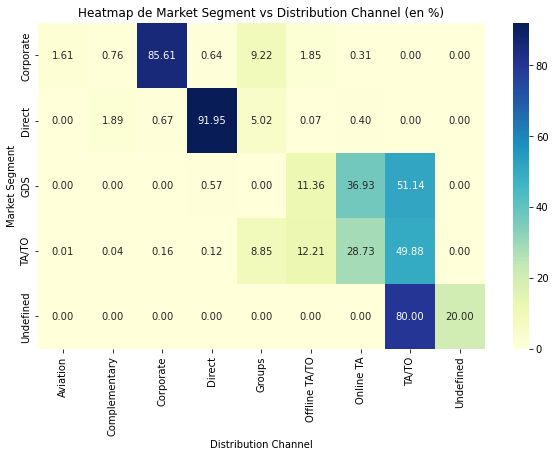

In [165]:
# Crear la tabla de contingencia con porcentajes
tabla_contingencia_pct = pd.crosstab(df['distribution_channel'], df['market_segment'], normalize='index') * 100

# Crear el heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(tabla_contingencia_pct, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)

# Personalizar el heatmap
plt.title('Heatmap de Market Segment vs Distribution Channel (en %)')
plt.ylabel('Market Segment')
plt.xlabel('Distribution Channel')
plt.show()